In [1]:
import os

try:
    snakemake
except NameError:
    from snakemk_util import load_rule_args
    
    os.chdir('../..')
    
    snakemake = load_rule_args(
        snakefile = os.getcwd() + "/workflow/Snakefile",
        rule_name = 'lapa_pilot_atlas',
        root = '..',
    )

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
from lapa.result import LapaResult
from collections import Counter
import matplotlib.pyplot as plt
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests

tqdm.pandas()

In [3]:
result = LapaResult(snakemake.input['long_reads'])
samples = result.samples

In [4]:
df = pd.concat([
    result.read_apa(i)
    .set_index(['Chromosome', 'Start', 'End', 'Strand', 'gene_id'])
    [['tpm', 'count', 'gene_count', 'usage']]
    .rename(columns={'tpm': f'tpm_{i}', 'count': f'count_{i}', 
                     'gene_count': f'gene_count_{i}', 'usage': f'usage_{i}'})
    for i in tqdm(samples)
], axis=1).fillna(0)

  0%|          | 0/51 [00:00<?, ?it/s]

In [5]:
df_samples = pd.DataFrame({
    'cell': pd.Series(samples).map(lambda x: '_'.join(x.split('_')[:-2])),
    'samples': pd.Series(samples)  
})

df_samples.head()

,cell,samples
0,panc1,panc1_1_1
1,gm12878,gm12878_1_1
2,k562,k562_2_2
3,gm23338,gm23338_1_2
4,gm23338,gm23338_1_1


In [11]:
from plotnine import *

In [29]:
_df = df.copy()
_df['Average Count'] = (df['count_wtc11_1_1'] + df['count_wtc11_1_2']) / 2
_df = _df.rename(columns={
    'count_wtc11_1_1': 'Number of reads polyA cluster, wtc11 (rep1)',
    'count_wtc11_1_2': 'Number of reads polyA cluster, wtc11 (rep2)',
})
(
    ggplot(aes(x='Number of reads polyA cluster, wtc11 (rep1)', 
               y='Number of reads polyA cluster, wtc11 (rep2)', 
               color='Average Count'), _df)
    + geom_point(alpha = 0.5) 
    + scale_x_log10() 
    + scale_y_log10()
    + scale_color_cmap(trans='log', breaks=[1, 10, 100, 1000, 10000])
).save('reports/figures/pilot_corr.png', dpi=300)

/data/homezvol2/mcelik/.conda/envs/lapa/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 6.4 x 4.8 in image.
/data/homezvol2/mcelik/.conda/envs/lapa/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: reports/figures/pilot_corr.png
/data/homezvol2/mcelik/.conda/envs/lapa/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
/data/homezvol2/mcelik/.conda/envs/lapa/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log


In [6]:
df_bar =  df[[f'tpm_{i}' for i in df_samples['samples']]]

In [11]:
df_bar = (df_bar > 0).reset_index('gene_id').groupby('gene_id').agg('sum')

In [13]:
df_apa_gene_plot = ((df_bar > 1).sum(axis=0) / (df_bar > 0).sum(axis=0)) \
    .reset_index().sort_values(by=0).rename(columns={'index':'samples', 0:'percent'})

df_apa_gene_plot['cell'] = df_apa_gene_plot['samples'].map(lambda x: '_'.join(x.split('_')[:-2]))

In [22]:
df_apa_gene_plot['cell'] = df_apa_gene_plot['cell'].str.replace('tpm_', '')

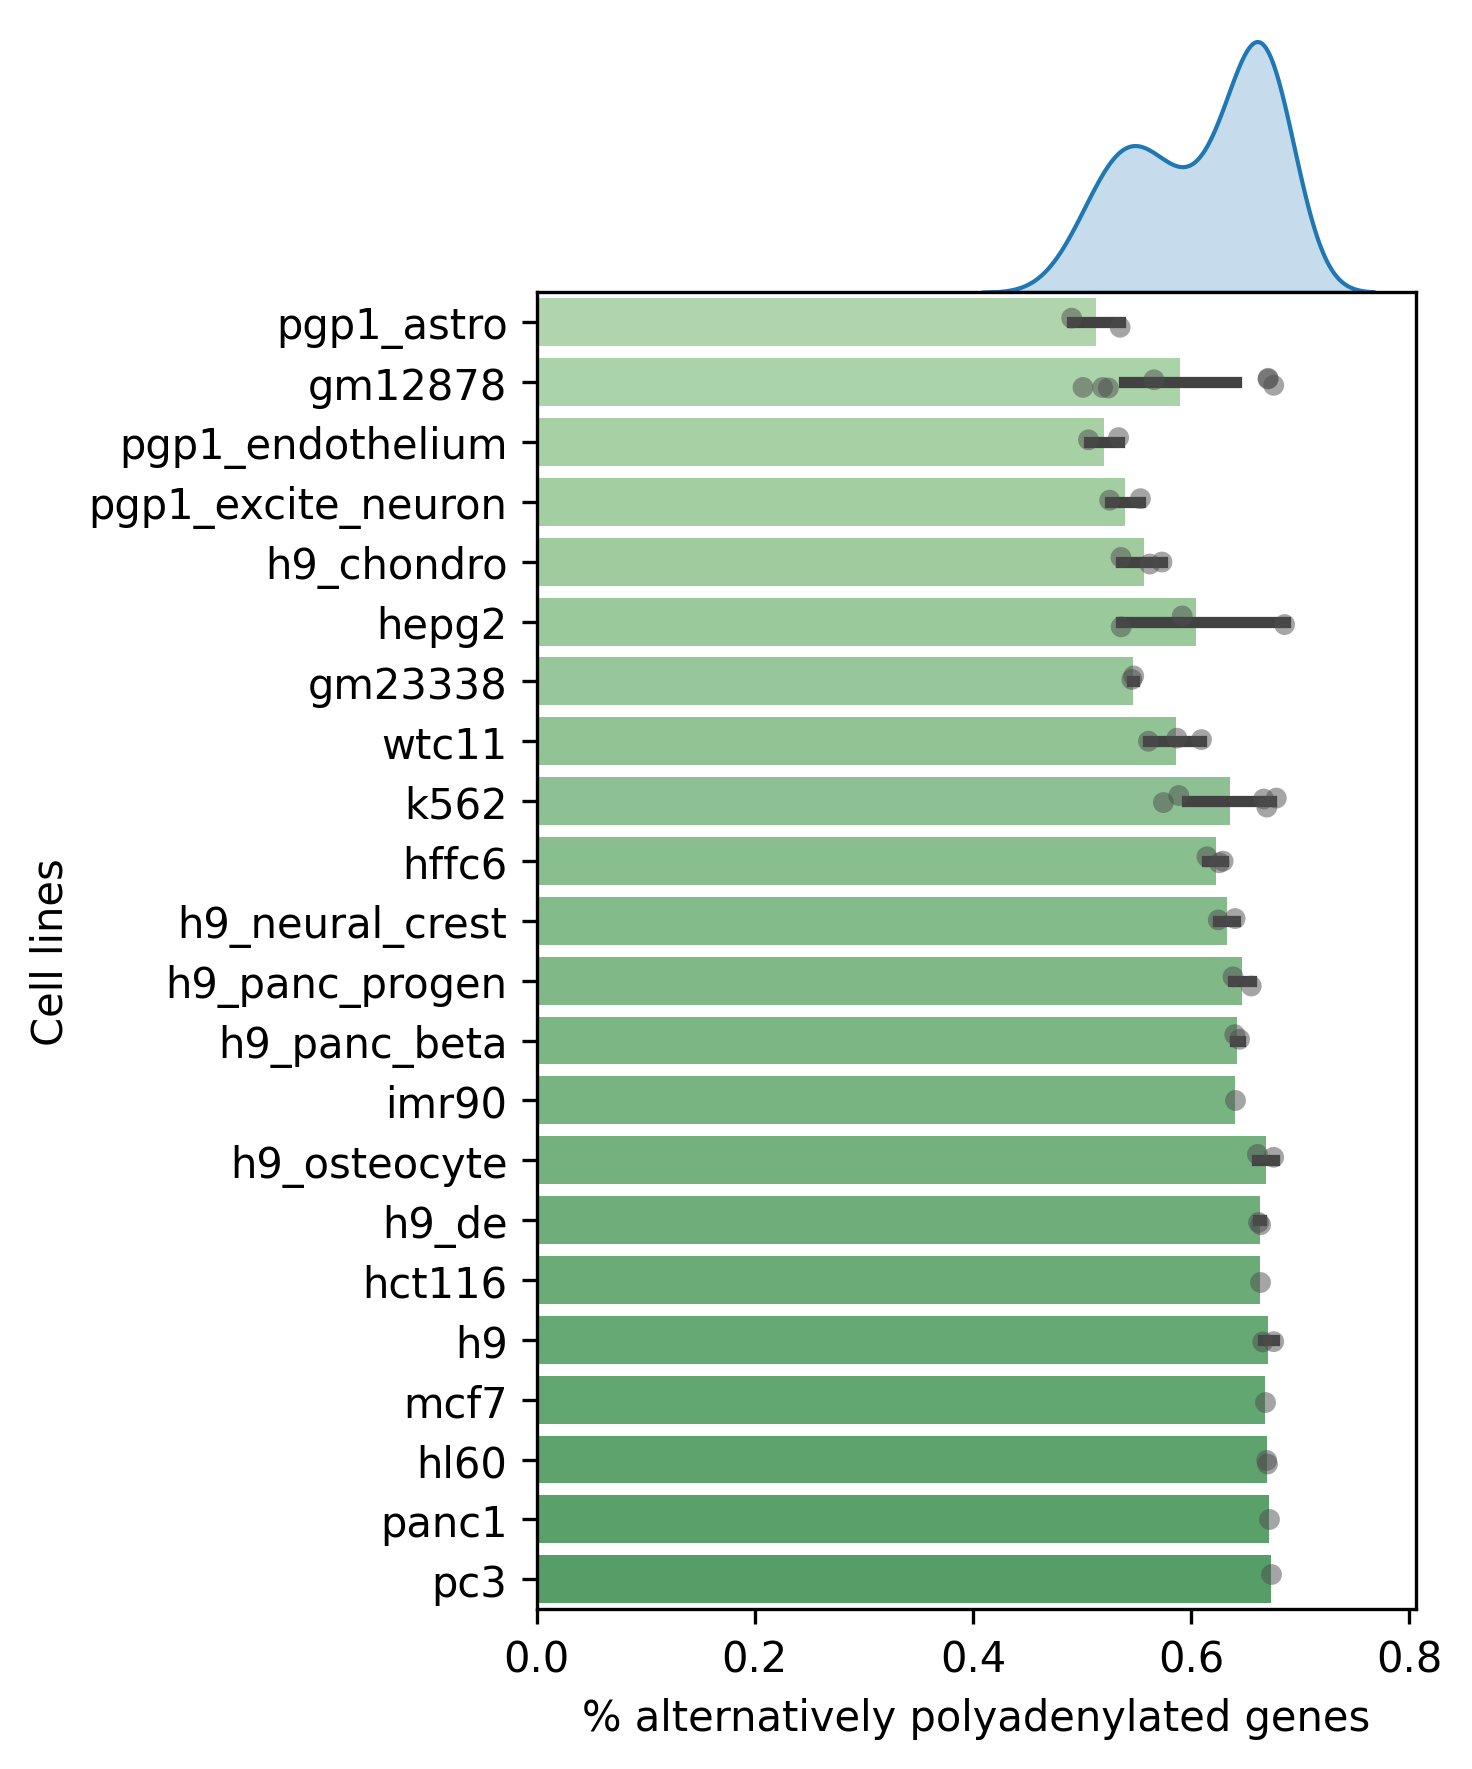

In [45]:
pal = sns.color_palette("Greens_d", len(df_apa_gene_plot))

rank = df_apa_gene_plot['percent'].argsort().argsort()

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(5, 6), 
                               gridspec_kw={'height_ratios': [1, 5]}, 
                               dpi=300, sharex=True)

sns.kdeplot(data=df_apa_gene_plot, x='percent', ax=ax1, fill=True)
ax1.axis('off')

sns.barplot(data=df_apa_gene_plot, y='cell', x='percent', palette=np.array(pal)[rank],  ax=ax2)
sns.stripplot(data=df_apa_gene_plot, y='cell', x='percent', color=".3", alpha=0.5)

plt.ylabel('Cell lines')
plt.xlabel('% alternatively polyadenylated genes')
fig.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

plt.savefig('reports/figures/percentage_poly_genes.png', dpi=300)

In [46]:
f'{df_apa_gene_plot["percent"].mean().round(2)} ± {df_apa_gene_plot["percent"].std().round(2)}'

'0.61 ± 0.06'

In [6]:
df_heatmap = pd.DataFrame()

for _, row in df_samples.groupby('cell').agg(list).iterrows():
    df_heatmap[row.name] = df[[f'usage_{i}' for i in row['samples']]].mean(axis=1)

In [7]:
#_df_heatmap = df_heatmap[df_heatmap.max(axis=1) > 0.3]
_df_heatmap = df_heatmap[df_heatmap.std(axis=1) > 0.3]
_df_heatmap = _df_heatmap.reset_index('gene_id').groupby('gene_id').agg('max')

In [8]:
_df_heatmap

,gm12878,gm23338,h9,h9_chondro,h9_de,h9_neural_crest,h9_osteocyte,h9_panc_beta,h9_panc_progen,hct116,...,hl60,imr90,k562,mcf7,panc1,pc3,pgp1_astro,pgp1_endothelium,pgp1_excite_neuron,wtc11
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000000005.6,0.000000,1.000000,1.00,0.000000,1.000,0.0,1.000000,1.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.0,1.000000
ENSG00000000938.13,0.965253,0.500000,0.00,0.000000,0.500,0.0,0.000000,0.000000,0.0,0.000000,...,0.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000,0.0,1.000000
ENSG00000000971.16,0.000000,0.000000,0.00,0.789841,0.000,0.0,0.402405,0.166667,0.0,0.000000,...,0.0,0.823529,0.444808,0.000000,0.000000,0.800000,0.805556,0.192424,0.0,0.000000
ENSG00000001617.12,0.000000,0.000000,0.00,0.922658,0.325,0.0,0.000000,0.000000,0.0,0.833333,...,0.0,0.684211,0.200000,0.923077,0.708333,0.591549,0.250000,0.500000,0.5,0.813862
ENSG00000002726.21,0.142857,0.000000,1.00,0.000000,0.000,0.0,0.000000,1.000000,0.5,1.000000,...,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000288705.1,0.000000,0.000000,0.00,0.000000,0.000,0.0,0.000000,1.000000,0.5,0.000000,...,0.0,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.333333
ENSG00000288706.1,0.000000,0.000000,0.00,0.000000,0.000,1.0,1.000000,1.000000,1.0,1.000000,...,0.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
ENSG00000288709.1,0.000000,0.000000,0.50,1.000000,0.000,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.946581


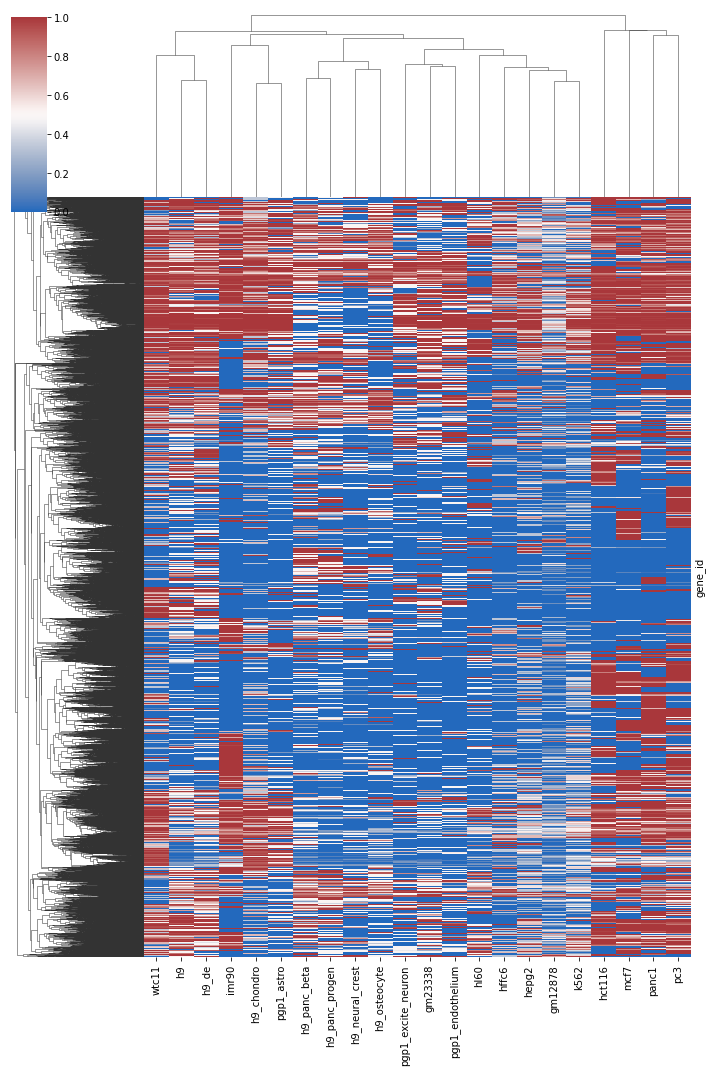

In [11]:
ax = sns.clustermap(_df_heatmap, yticklabels=False, cmap='vlag', figsize=(, 15))

plt.savefig('reports/figures/percentage_poly_genes.png', dpi=300)